In [4]:
import qetpy as qp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

from pprint import pprint
import pytesdaq.io.hdf5 as h5io
h5 = h5io.H5Reader()
import pickle

In [5]:
def read_file(file_name): 
    traces, info = h5.read_many_events(filepath=file_name, output_format=2, 
                                       include_metadata=True,
                                       adctoamp=True)
    detector_settings = h5.get_detector_config(file_name=file_name)
    channels = info[0]['detector_chans']
    sample_rate = info[0]['sample_rate']
    
    return traces, channels, sample_rate, detector_settings

In [7]:
# Other IR data, signal gen set too low 
'''
data_list = dict()
base_path = '/sdata2/runs/run35/raw/didv_I2_D20231114_T160934'
data_list[762] = base_path + '/didv_I2_D20231114_T161020_F0001.hdf5'
data_list[790] = base_path + '/didv_I2_D20231114_T161227_F0001.hdf5'
data_list[820] = base_path + '/didv_I2_D20231114_T161435_F0001.hdf5'
data_list[850] = base_path + '/didv_I2_D20231114_T161641_F0001.hdf5'
data_list[880] = base_path + '/didv_I2_D20231114_T161848_F0001.hdf5'
data_list[910] = base_path + '/didv_I2_D20231114_T162056_F0001.hdf5'
''';

In [66]:
#/sdata2/runs/run35/raw/didv_I2_D20231115_T155440
data_list = dict()
base_path = '/sdata2/runs/run35/raw/didv_I2_D20231115_T155440'
data_list[762] = base_path + '/didv_I2_D20231115_T155527_F0001.hdf5'
data_list[790] = base_path + '/didv_I2_D20231115_T155743_F0001.hdf5'
data_list[820] = base_path + '/didv_I2_D20231115_T160001_F0001.hdf5'
data_list[850] = base_path + '/didv_I2_D20231115_T160219_F0001.hdf5'
data_list[880] = base_path + '/didv_I2_D20231115_T160436_F0001.hdf5'
data_list[910] = base_path + '/didv_I2_D20231115_T160652_F0001.hdf5'

In [68]:
print(traces_chan.shape)
print(traces_chan[cut].shape)

(882, 77500)
(208, 77500)


Starting CPDv21Al2O3 fitting at 762 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


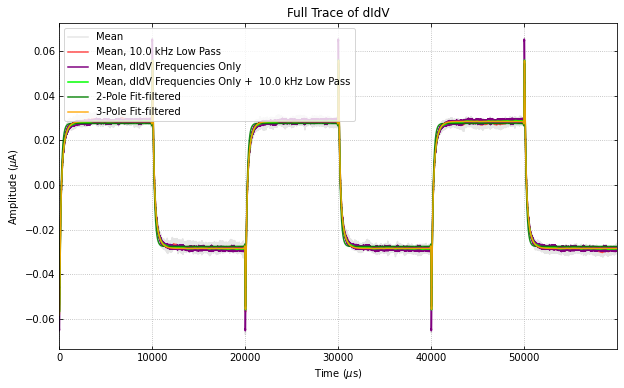

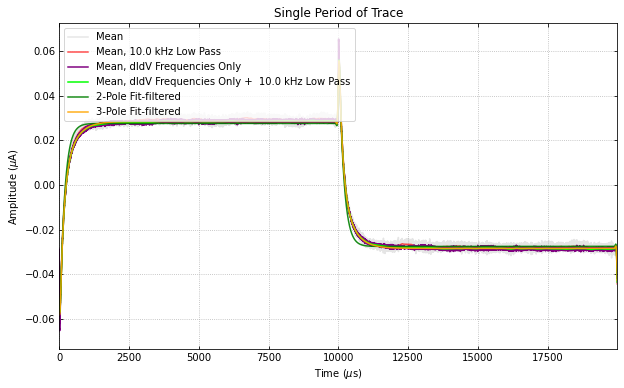

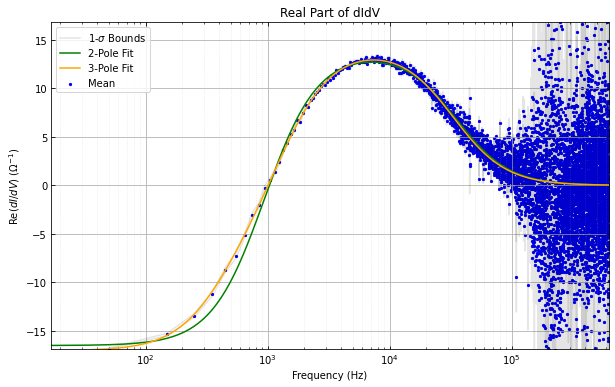

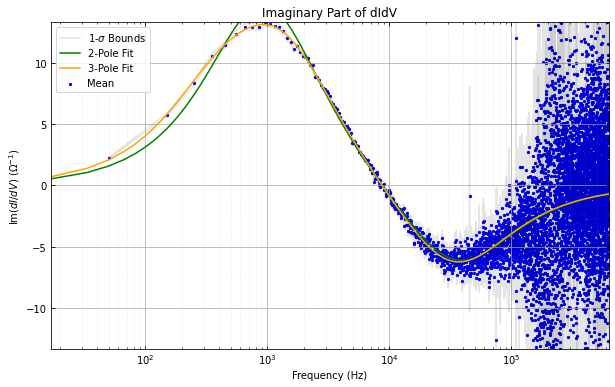

CPDv21Al2O3 bias power @ 762 mK = 0.3166406348473908 pWatts
Starting CPDv21Al2O3 fitting at 790 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


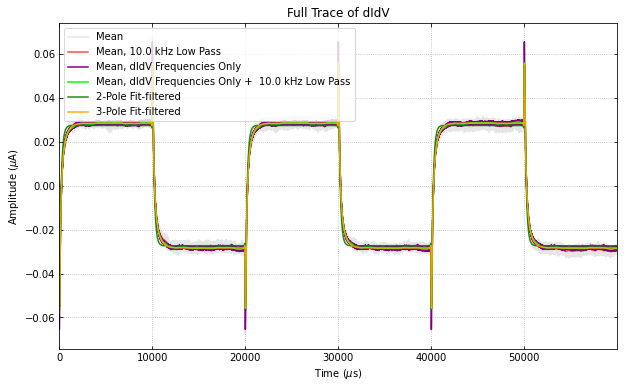

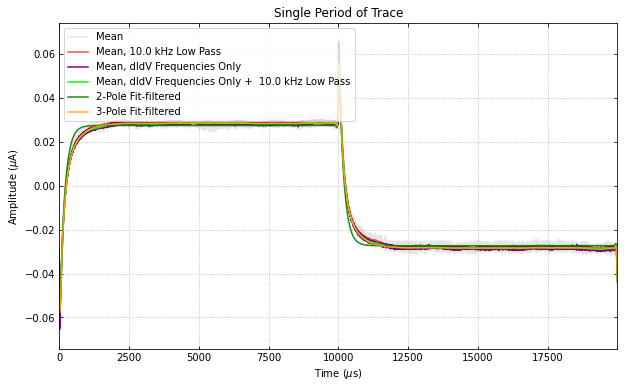

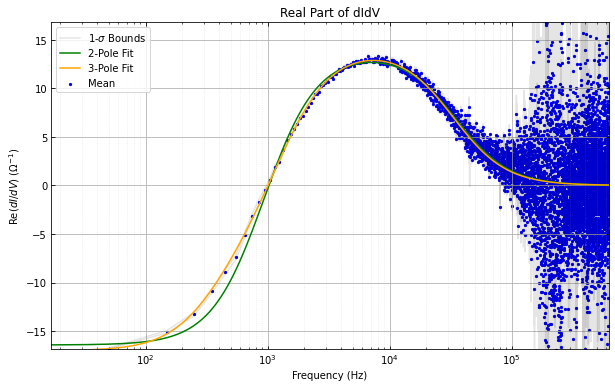

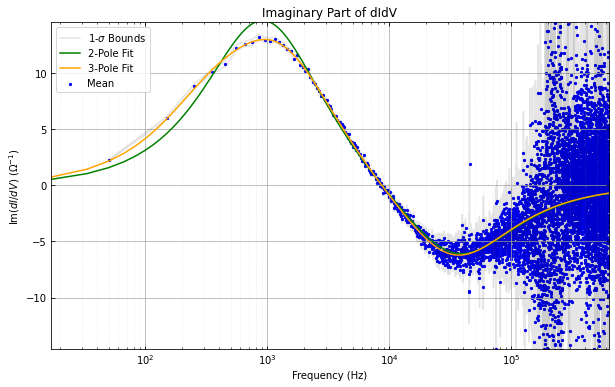

CPDv21Al2O3 bias power @ 790 mK = 0.3165651685912972 pWatts
Starting CPDv21Al2O3 fitting at 820 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


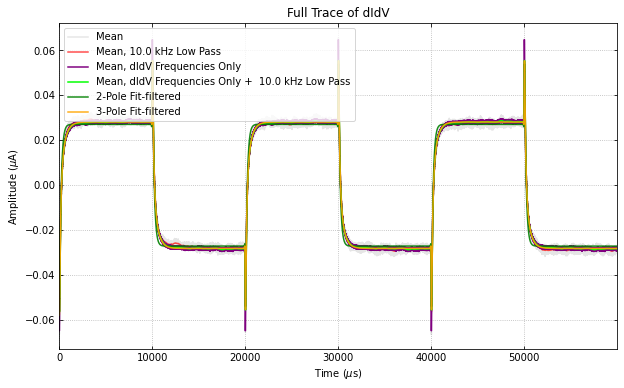

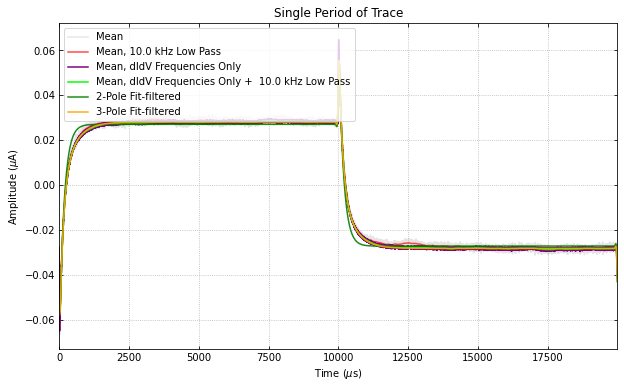

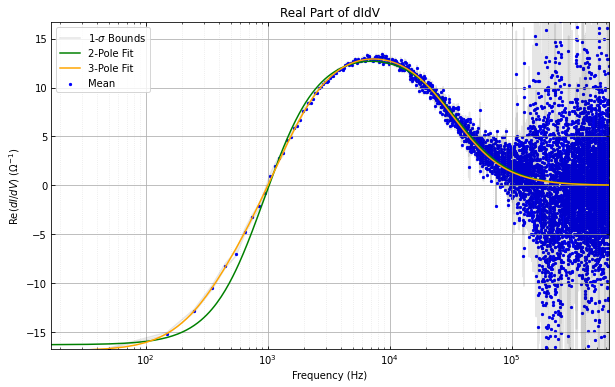

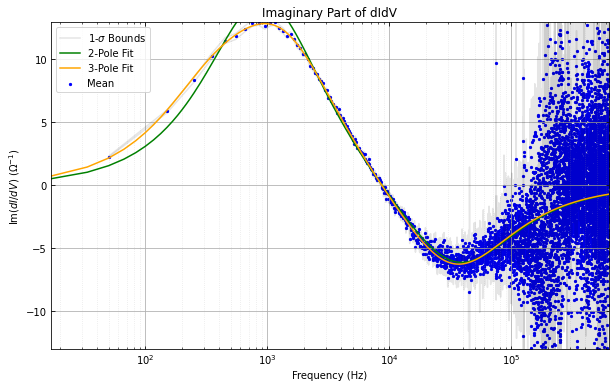

CPDv21Al2O3 bias power @ 820 mK = 0.3147757945747859 pWatts
Starting CPDv21Al2O3 fitting at 850 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


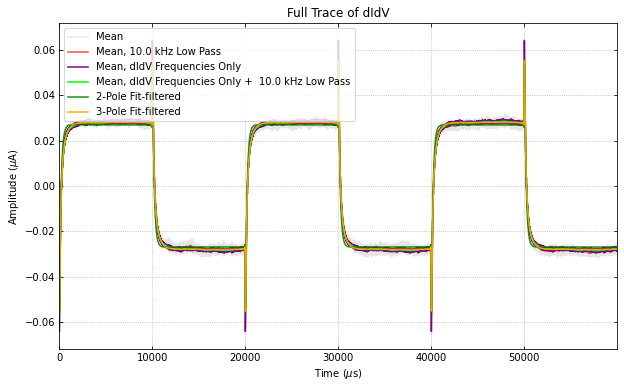

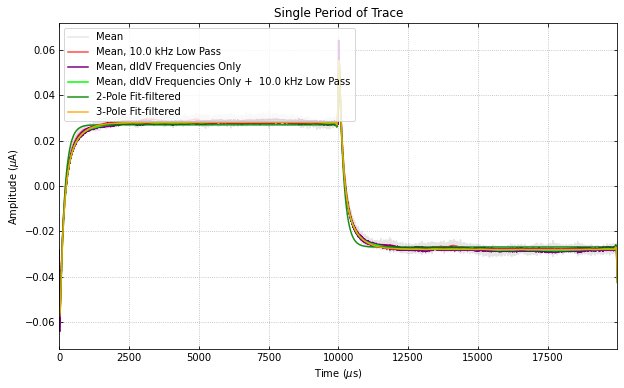

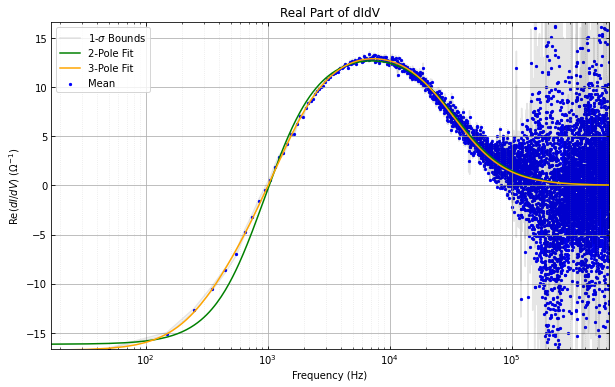

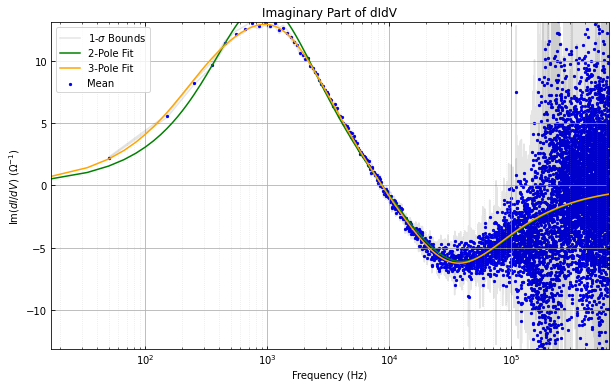

CPDv21Al2O3 bias power @ 850 mK = 0.3135297150966654 pWatts
Starting CPDv21Al2O3 fitting at 880 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


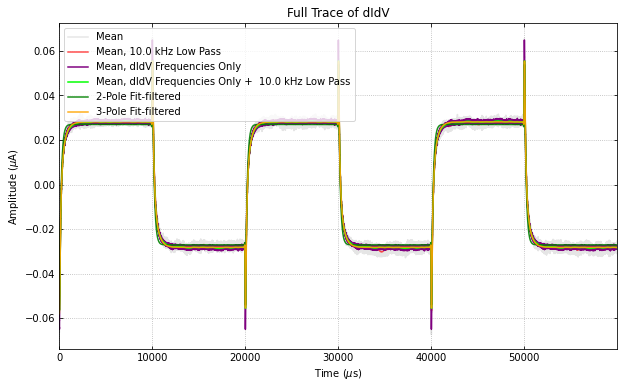

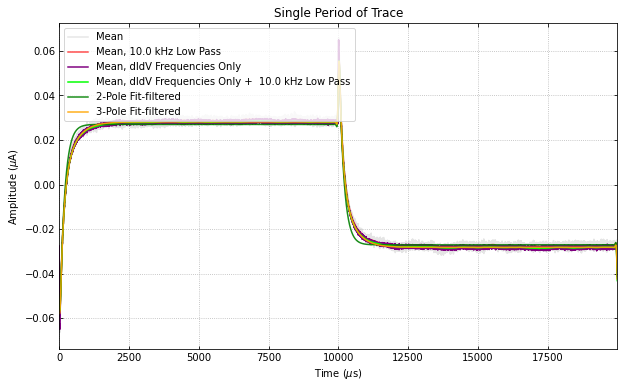

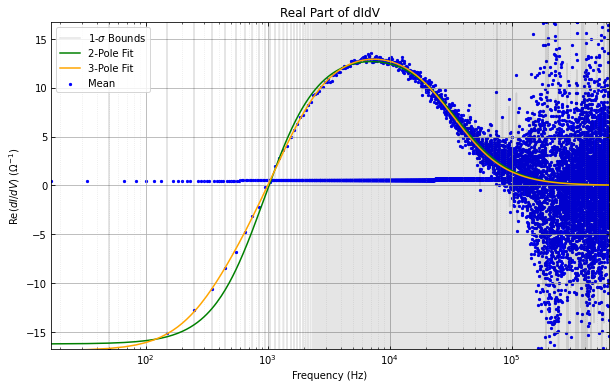

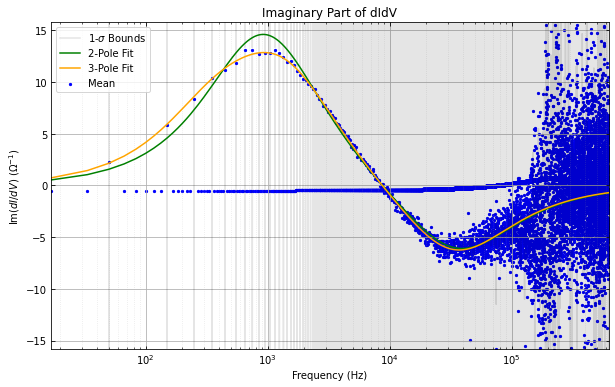

CPDv21Al2O3 bias power @ 880 mK = 0.31464696861023855 pWatts
Starting CPDv21Al2O3 fitting at 910 mK...
Finished CPDv21Al2O3 autocuts!
Starting dIdV processing and fitting...
Done with fitting!


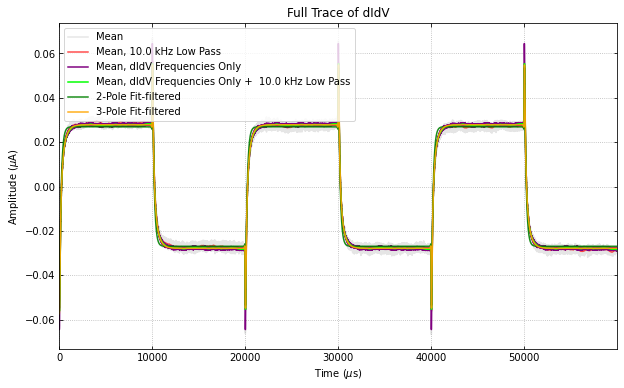

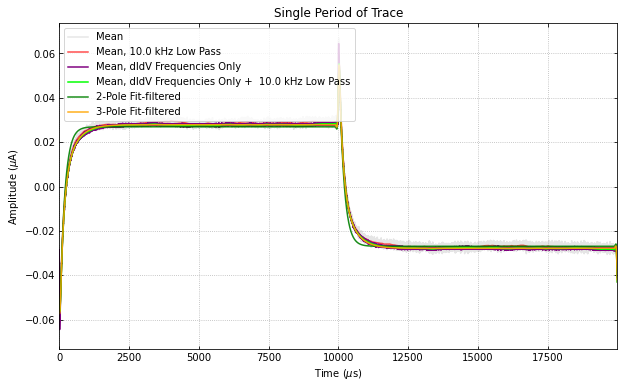

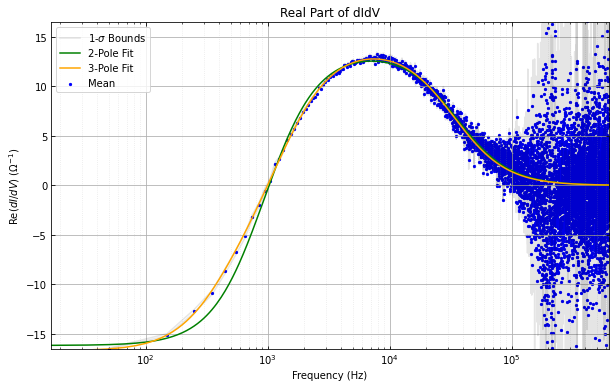

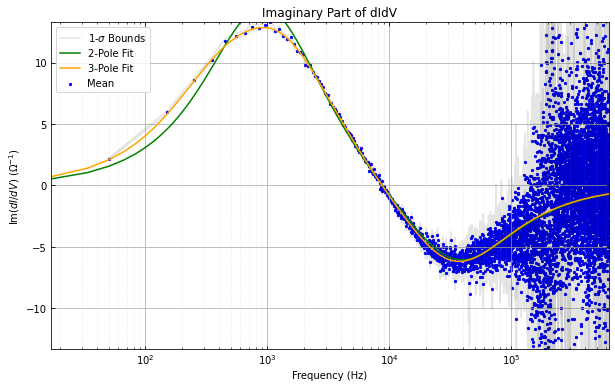

CPDv21Al2O3 bias power @ 910 mK = 0.31242258316972976 pWatts


In [67]:
#%matplotlib notebook

power_dict = dict()
chan_rp = [0.00365,0.00265,0.00255]
# channel to calculate power
channel_selection = ['CPDv21Al2O3']
display_fit = True
colors = ["red", "green", "blue", 'purple', 'orange', 'yellow']
cuts_dict = {'minmax': {'sigma': 2.5},
             'baseline': {'sigma': 2},
             'ofamps':  {'sigma':2},
             'slope': {'sigma' :2.5},
             'ofchi2': {'sigma': 2.5}
            }
#fig, ax = plt.subplots(figsize=(10, 6))

# loop data
i=0
for temperature, file in data_list.items():
    # load traces all channels [Nbevents, Nb channels, NB samples]
    traces, channels, sample_rate, detector_settings = read_file(file)
    # Temporary channels
    channels = ['IrPtTESSmallV2', 'IrPtTESBigV2', 'CPDv21Al2O3']
    # loop channels
    power_dict[temperature] = dict()
    for ind, chan in enumerate(channels):
        # only selected channels
        if chan not in channel_selection:
            continue
        # store 2D trace for the channel
        print(f'Starting {chan} fitting at {temperature} mK...')
        traces_chan = traces[:,ind]
        rp = chan_rp[ind]
        # detector settings
        rshunt = float(detector_settings[chan]['shunt_resistance'])
        signal_gen_frequency = float(detector_settings[chan]['signal_gen_frequency'])
        signal_gen_current = float(detector_settings[chan]['signal_gen_current'])
        tes_bias = float(detector_settings[chan]['tes_bias'])
        voltage_bias = tes_bias*rshunt
        
        
        # cut pileup
        precut_traces = len
        cut = qp.autocuts_didv(traces_chan,fs=sample_rate, cuts_dict=cuts_dict)
        print(f'Finished {chan} autocuts!')
        dis_trace = traces_chan[cut].mean(axis=0)
        dis_trace = (dis_trace.max()+dis_trace.min())/2-dis_trace
        
        '''
        ax.plot(dis_trace*1e6, label=str(temperature)+" mK", color=colors[i])
        ax.legend()
        ax.set_title("didV: "+chan)
        ax.set_xlabel("Time (μs)")
        ax.set_ylabel("Amplitude (μA)")
        ''';
        # Fit data
        print(f'Starting dIdV processing and fitting...')
        didvobj = qp.DIDV(traces_chan[cut], 
                          sample_rate, 
                          signal_gen_frequency, signal_gen_current, 
                          rshunt, rp=rp, dt0=3.4e-6, dutycycle=0.5, add180phase=False)
        didvobj.processtraces()
        didvobj.dofit(2)
        didvobj.dofit(3)
        result = didvobj.fitresult(3)
        print(f'Done with fitting!')
        # display fit
        if display_fit:
            didvobj.plot_full_trace(lp_cutoff=10e3, didv_freq_filt=True, gray_mean=True,)
            didvobj.plot_single_period_of_trace(lp_cutoff=10e3, didv_freq_filt=True, gray_mean=True)
            didvobj.plot_re_im_didv()

                
        ###  calc power 
        # TES resistance 
        r_tes = abs(1/result['didv0']) + rp + rshunt
        
        # current in TES 
        i_tes = voltage_bias/(r_tes + rp + rshunt)
        
        # Power = V x I   (- load power rload*i_tes^2  (in pico Watt)
        #power_tes = 1e12 *(voltage_bias*i_tes - (rp+rshunt)*pow(i_tes,2))
        power_tes = 1e12 *(r_tes*pow(i_tes,2))

        print(chan + ' bias power @ ' + str(temperature) + ' mK = ' + str(power_tes) + ' pWatts')
        
        power_dict[temperature] = power_tes
        
        
    i+=1
                 
           

In [31]:
print(power_dict.keys())
print(power_dict.values())

dict_keys([762, 790, 820, 850, 880, 910])
dict_values([0.3004345628483098, 0.3035498159540825, 0.3110075167601727, 0.3147400424854405, 0.2981591754067811, 0.2936407439221758])


In [69]:
power_values = np.asarray(list(power_dict.values()))

In [70]:
power_values

array([0.31664063, 0.31656517, 0.31477579, 0.31352972, 0.31464697,
       0.31242258])

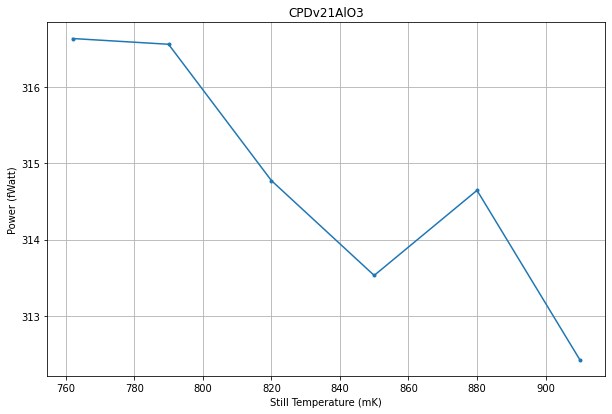

In [71]:
# Plot power in function of temperature
plt.plot(power_dict.keys(), power_values*1e3, marker=".")
#plt.legend()
plt.ylabel("Power (fWatt)")
plt.xlabel("Still Temperature (mK)")
plt.title("CPDv21AlO3")
plt.grid('both')
plt.show()